The following code reproduces continuous time stochastic simulations performed in the HSC boolean network from  **Herrera et al. 2024. A system-Level Model Reveals that Transcriptional Stochasticity is Required for Hematopoietic Stem Cell Differentiation**. For this purpose we used the PyMaBoSS, a Python interface for MaBoSS software (Stoll G et al., MaBoSS 2.0: an environment for stochastic Boolean modeling. Bioinformatics btx123. 2017 Mar.) It can be launched at the CoLoMoTo Notebook enviroment (https://colomoto.github.io/notebook/)

In [ ]:
# Import dependencies
import maboss
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd


In [ ]:
# Load the netwok in MaBoSS style.
HSC_sim = maboss.load("maboss_HSC.bnd", "maboss_HSC.cfg")

# Stablish simulation parameters
HSC_sim.update_parameters(discrete_time=0, use_physrandgen=0,
        seed_pseudorandom=100, sample_count=1000000,
        max_time=50, time_tick=0.1, thread_count=4,
        statdist_traj_count=20000, statdist_cluster_threshold=0.9)

In [ ]:
# Run the simulation and plot all attained stable states
HSC_results = HSC_sim.run()

In [ ]:

# Plot the frequency of every cell type as defined by specified marker TFs
HSC_states = HSC_sim.copy()
HSC_states.network.set_output(('GATA2', 'GATA1', 'PU1', 'Gfi1'))
HSC_states_results = HSC_states.run()
HSC_states_results.plot_piechart()

# Dataframe containing fixed points info
fp_table = HSC_results.get_fptable()
# Select columns excluding 'State'
fp_table = fp_table[['FP', 'Proba', 'Oxygen', 'Runx1', 'Meis1', 'HIF1', 'FOXO3', 'p53', 'GATA2', 'GATA1', 'PU1', 'Cebpa', 'Ikzf1', 'Gfi1', 'Mef2c', 'mTOR', 'AMPK', 'AKT', 'H2O2', 'O2', 'SOD', 'Antiox', 'OXPHOS']]

# Create the Identity column based on the specified markers
def determine_identity(row):
    if row['GATA2'] == 1:
        return 'HSC'
    elif row['GATA1'] == 1:
        return 'MEP'
    elif row['PU1'] == 1:
        return 'GMP'
    elif row['Gfi1'] == 1:
        return 'CLP'
    else:
        return 'Undefined'

fp_table['Identity'] = fp_table.apply(determine_identity, axis=1)

# Transpose the DataFrame
fp_table = fp_table.transpose()

# Eliminate the first row (originally 'FP' row in transposed table)
fp_table = fp_table.iloc[1:]

# Replace the column headers
fp_table.columns = [f'Attr {i}' for i in range(1, fp_table.shape[1] + 1)]

# Create the summary table: sum of Proba grouped by Identity
identity_summary = fp_table.T.groupby('Identity')['Proba'].sum().reset_index()

# Convert the identity summary to a text string
identity_summary_text = "\n".join([f"{row['Identity']}: {row['Proba']:.2f}" for _, row in identity_summary.iterrows()])

# Create a PDF file and save the tables
with PdfPages('Stochastic_attractors.pdf') as pdf:
    # Page 1: Original fp_table with text summary below
    fig, ax = plt.subplots(figsize=(12, len(fp_table)*0.6))  # Decreased figure width for less white space
    ax.set_title('Attractors identified through stochastic exploration ', fontsize=14, weight='bold')  # Add title
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=fp_table.values, rowLabels=fp_table.index, colLabels=fp_table.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(8)  # Reduced font size for better fit
    table.scale(1.2, 1.2)  # Adjust the table scale to reduce white space
    
    
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)




In [ ]:
# Plot the frequencie of every cell type as defined by specified marker TFs and the Oxygen concentration set to 0
HSC_states_Oxygen_0 = HSC_sim.copy()
maboss.set_nodes_istate(HSC_states_Oxygen_0, ["Oxygen",], [1, 0])
HSC_states_Oxygen_0.network.set_output(('GATA2', 'GATA1', 'PU1', 'Gfi1'))
HSC_states_Oxygen_0_results = HSC_states_Oxygen_0.run()
HSC_states_Oxygen_0_results.plot_piechart()


In [ ]:
# Plot the frequencie of every cell type as defined by specified marker TFs and the Oxygen concentration set to 1
HSC_states_Oxygen_1 = HSC_sim.copy()
maboss.set_nodes_istate(HSC_states_Oxygen_1, ["Oxygen"], [0, 1])
HSC_states_Oxygen_1.network.set_output(('GATA2', 'GATA1', 'PU1', 'Gfi1'))
HSC_states_Oxygen_1_results = HSC_states_Oxygen_1.run()
HSC_states_Oxygen_1_results.plot_piechart()


In [ ]:
#Changes the probabilty distribution of inactive nodes

# Values for values_istate_2 in each iteration
values_istate_2_list = [
    [0.9, 0.1],
    [0.8, 0.2],
    [0.7, 0.3],
    [0.6, 0.4],
    [0.5, 0.5]
]

for i, values_istate_2 in enumerate(values_istate_2_list, start=1):
    # Genetic drift simulation and initial setup
    background_noise = HSC_sim.copy()

    nodes_istate_1 = ["Oxygen"]
    values_istate_1 = [1, 0]

    nodes_istate_2 = ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"]

    nodes_istate_3 = ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"]
    values_istate_3 = [0, 1]

    # Set initial states
    maboss.set_nodes_istate(background_noise, nodes_istate_1, values_istate_1)
    maboss.set_nodes_istate(background_noise, nodes_istate_2, values_istate_2)
    maboss.set_nodes_istate(background_noise, nodes_istate_3, values_istate_3)

    background_noise.network.set_output(('GATA2', 'GATA1', 'PU1', 'Gfi1'))
    background_noise_results = background_noise.run()

    background_entropy = background_noise_results.get_entropy_trajectory()
    background_noise_df = background_noise_results.get_states_probtraj()
    time = background_noise_df.index

    # Specific colors for the requested sequences
    colors = {
        'GATA2': '#800080',  
        'GATA1': '#E5007E',  
        'PU1': '#B185BA',    
        'Gfi1': '#4F5AA4'    
    }

    # Specific labels for the requested sequences
    labels_map = {
        'GATA2': 'HSC',
        'GATA1': 'MEP',
        'PU1': 'GMP',
        'Gfi1': 'CLP'
    }

    # Plot the state probabilities (noise)
    plt.figure(figsize=(10, 8))

    lines = []
    labels = []

    others_line = None  # Line for the sequences grouped as "Others"
    for column in background_noise_df.columns:
        color = colors.get(column, '#808080')  # Gray for unspecified columns
        line, = plt.plot(time, background_noise_df[column], linewidth=3, color=color, alpha=0.8 if color == '#808080' else 1)

        if column in labels_map:
            lines.append(line)
            labels.append(labels_map[column])
        else:
            others_line = line

    # Add the "Others" line if it exists
    if others_line:
        lines.append(others_line)
        labels.append("Others")

    # Modify axis labels
    plt.xlabel('Time [a. u.]', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.xticks(np.arange(0, 25, 5))
    plt.tick_params(axis='both', which='major', labelsize=20)  # Change 14 to the desired size

    # Fix the y-axis between 0 and 1
    plt.ylim(0, 1)

    # Add the legend with correct colors and labels
    plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=18, frameon=False)

    # Add the grid
    plt.grid(False)

    # Save the plot to a PDF with suffix
    with PdfPages(f"background_noise_{i}.pdf") as pdf:
        pdf.savefig(bbox_inches='tight')

    plt.close()

    # Entropy plot
    with PdfPages(f'background_entropy_{i}.pdf') as pdf:
        plt.figure(figsize=(10, 8))
        plt.plot(background_entropy['TH'], label='TH', color='#1f77b4', linewidth=3)  # Blue
        plt.plot(background_entropy['H'], label='H', color='#ff7f0e', linewidth=3)  # Orange
        plt.xlabel('Time [a. u.]', fontsize=20)
        plt.ylabel('Bits', fontsize=20)
        plt.xticks(np.arange(0, 25, 5))
        plt.tick_params(axis='both', which='major', labelsize=20)

        # Fix the y-axis between 0 and 4
        plt.ylim(0, 4)

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=18, frameon=False)

        # Add the grid
        plt.grid(False)

        pdf.savefig(bbox_inches='tight')
        plt.close()



In [ ]:
#Changes the probabilty distribution of active nodes
values_istate_3_list = [
    [0.1, 0.9],
    [0.2, 0.8],
    [0.3, 0.7],
    [0.4, 0.6],
    [0.5, 0.5]
]

for i, values_istate_3 in enumerate(values_istate_3_list, start=1):
    # Genetic drift simulation and initial setup
    background_noise = HSC_sim.copy()

    nodes_istate_1 = ["Oxygen"]
    values_istate_1 = [1, 0]

    nodes_istate_2 = ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"]
    values_istate_2 = [1, 0]

    nodes_istate_3 = ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"]

    # Set initial states
    maboss.set_nodes_istate(background_noise, nodes_istate_1, values_istate_1)
    maboss.set_nodes_istate(background_noise, nodes_istate_2, values_istate_2)
    maboss.set_nodes_istate(background_noise, nodes_istate_3, values_istate_3)

    background_noise.network.set_output(('GATA2', 'GATA1', 'PU1', 'Gfi1'))
    background_noise_results = background_noise.run()

    background_entropy = background_noise_results.get_entropy_trajectory()
    background_noise_df = background_noise_results.get_states_probtraj()
    time = background_noise_df.index

    # Specific colors for the requested sequences
    colors = {
        'GATA2': '#800080',  
        'GATA1': '#E5007E',  
        'PU1': '#B185BA',    
        'Gfi1': '#4F5AA4'   
    }

    # Specific labels for the requested sequences
    labels_map = {
        'GATA2': 'HSC',
        'GATA1': 'MEP',
        'PU1': 'GMP',
        'Gfi1': 'CLP'
    }

    # Plot the state probabilities (noise)
    plt.figure(figsize=(10, 8))

    lines = []
    labels = []

    others_line = None  # Line for the sequences grouped as "Others"
    for column in background_noise_df.columns:
        color = colors.get(column, '#808080')  # Gray for unspecified columns
        line, = plt.plot(time, background_noise_df[column], linewidth=3, color=color, alpha=0.8 if color == '#808080' else 1)

        if column in labels_map:
            lines.append(line)
            labels.append(labels_map[column])
        else:
            others_line = line

    # Add the "Others" line if it exists
    if others_line:
        lines.append(others_line)
        labels.append("Others")

    # Modify axis labels
    plt.xlabel('Time [a. u.]', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.xticks(np.arange(0, 25, 5))
    plt.tick_params(axis='both', which='major', labelsize=20)

    # Fix the y-axis between 0 and 1
    plt.ylim(0, 1)

    # Add the legend with correct colors and labels
    plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=18, frameon=False)

    # Add the grid
    plt.grid(False)

    # Save the plot to a PDF with suffix
    with PdfPages(f"regulators_noise_{i}.pdf") as pdf:
        pdf.savefig(bbox_inches='tight')

    plt.close()

    # Entropy plot
    with PdfPages(f'regulators_entropy_{i}.pdf') as pdf:
        plt.figure(figsize=(10, 8))
        plt.plot(background_entropy['TH'], label='TH', color='#1f77b4', linewidth=3)  # Blue
        plt.plot(background_entropy['H'], label='H', color='#ff7f0e', linewidth=3)  # Orange
        plt.xlabel('Time [a. u.]', fontsize=20)
        plt.ylabel('Bits', fontsize=20)
        plt.xticks(np.arange(0, 25, 5))
        plt.tick_params(axis='both', which='major', labelsize=20)

        # Fix the y-axis between 0 and 4
        plt.ylim(0, 4)

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=18, frameon=False)

        # Add the grid
        plt.grid(False)

        pdf.savefig(bbox_inches='tight')
        plt.close()



In [ ]:
#Changes the probabilty distribution of active and inactive nodes
values_istate_2_list = [
    [0.9, 0.1],
    [0.8, 0.2],
    [0.7, 0.3],
    [0.6, 0.4],
    [0.5, 0.5]
]

values_istate_3_list = [
    [0.1, 0.9],
    [0.2, 0.8],
    [0.3, 0.7],
    [0.4, 0.6],
    [0.5, 0.5]
]

for i in range(5):
    # Genetic drift simulation and initial setup
    background_noise = HSC_sim.copy()

    nodes_istate_1 = ["Oxygen"]
    values_istate_1 = [1, 0]

    nodes_istate_2 = ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"]
    values_istate_2 = values_istate_2_list[i]

    nodes_istate_3 = ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"]
    values_istate_3 = values_istate_3_list[i]

    # Set initial states
    maboss.set_nodes_istate(background_noise, nodes_istate_1, values_istate_1)
    maboss.set_nodes_istate(background_noise, nodes_istate_2, values_istate_2)
    maboss.set_nodes_istate(background_noise, nodes_istate_3, values_istate_3)

    background_noise.network.set_output(('GATA2', 'GATA1', 'PU1', 'Gfi1'))
    background_noise_results = background_noise.run()

    background_entropy = background_noise_results.get_entropy_trajectory()
    background_noise_df = background_noise_results.get_states_probtraj()
    time = background_noise_df.index

    # Specific colors for the requested sequences
    colors = {
        'GATA2': '#800080',  
        'GATA1': '#E5007E',  
        'PU1': '#B185BA',   
        'Gfi1': '#4F5AA4'    
    }

    # Specific labels for the requested sequences
    labels_map = {
        'GATA2': 'HSC',
        'GATA1': 'MEP',
        'PU1': 'GMP',
        'Gfi1': 'CLP'
    }

    # Plot the state probabilities (noise)
    plt.figure(figsize=(10, 8))

    lines = []
    labels = []

    others_line = None  # Line for the sequences grouped as "Others"
    for column in background_noise_df.columns:
        color = colors.get(column, '#808080')  # Gray for unspecified columns
        line, = plt.plot(time, background_noise_df[column], linewidth=3, color=color, alpha=0.8 if color == '#808080' else 1)

        if column in labels_map:
            lines.append(line)
            labels.append(labels_map[column])
        else:
            others_line = line

    # Add the "Others" line if it exists
    if others_line:
        lines.append(others_line)
        labels.append("Others")

    # Modify axis labels
    plt.xlabel('Time [a. u.]', fontsize=20)
    plt.ylabel('Probability', fontsize=20)
    plt.xticks(np.arange(0, 25, 5))
    plt.tick_params(axis='both', which='major', labelsize=20)

    # Fix the y-axis between 0 and 1
    plt.ylim(0, 1)

    # Add the legend with correct colors and labels
    plt.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=20, frameon=False, fontsize=18)

    # Add the grid
    plt.grid(False)

    # Save the plot to a PDF with suffix
    with PdfPages(f"both_noise_{i + 1}.pdf") as pdf:
        pdf.savefig(bbox_inches='tight')

    plt.close()

    # Entropy plot
    with PdfPages(f'both_entropy_{i + 1}.pdf') as pdf:
        plt.figure(figsize=(10, 8))
        plt.plot(background_entropy['TH'], label='TH', color='#1f77b4', linewidth=3)  # Blue
        plt.plot(background_entropy['H'], label='H', color='#ff7f0e', linewidth=3)  # Orange
        plt.xlabel('Time [a. u.]', fontsize=20)
        plt.ylabel('Bits', fontsize=20)
        plt.xticks(np.arange(0, 25, 5))
        plt.tick_params(axis='both', which='major', labelsize=20)

        # Fix the y-axis between 0 and 4
        plt.ylim(0, 4)

        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=18, frameon=False)

        # Add the grid
        plt.grid(False)

        pdf.savefig(bbox_inches='tight')
        plt.close()


In [ ]:
# Create a plot of transient states with the expression of different lineage markers

# Define simulation values for specific nodes
simulation_values = [
    {"values": [0.2, 0.8], "label": "0.2, 0.8"},
    {"values": [0.5, 0.5], "label": "0.5, 0.5"}
]

# Create a PDF file to save the plots in A4 size
with PdfPages('Transient States.pdf') as pdf:
    # Loop over simulation values
    for sim in simulation_values:
        # Perform the simulation and obtain the results
        Oxygen_states = HSC_sim.copy()
        maboss.set_nodes_istate(Oxygen_states, ["Oxygen"], [1, 0])
        maboss.set_nodes_istate(Oxygen_states, ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"], sim["values"])
        maboss.set_nodes_istate(Oxygen_states, ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"], [0, 1])
        Oxygen_states.network.set_output(["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1"])

        Oxygen_states_results = Oxygen_states.run()

        # Obtain the DataFrame of trajectories
        db = Oxygen_states_results.get_states_probtraj()

        # Define the combinations of co-expression we want to plot with different color palettes
        combinations = {
            "GATA2, PU1, Meis1, Cebpa": {"genes": ["GATA2", "PU1", "Meis1", "Cebpa"], "palette": "viridis"},
            "GATA2, GATA1": {"genes": ["GATA2", "GATA1"], "palette": "inferno"},
            "GATA2, PU1": {"genes": ["GATA2", "PU1"], "palette": "cool"},
            "GATA2, Gfi1": {"genes": ["GATA2", "Gfi1"], "palette": "spring"},
            "GATA2, GATA1, PU1, Gfi1": {"genes": ["GATA2", "GATA1", "PU1", "Gfi1"], "palette": "cividis"},
            "GATA1, PU1, Gfi1": {"genes": ["GATA1", "PU1", "Gfi1"], "palette": "magma"},
            "GATA1, PU1": {"genes": ["GATA1", "PU1"], "palette": "plasma"},
            "GATA1, Gfi1": {"genes": ["GATA1", "Gfi1"], "palette": "summer"},
            "PU1, Gfi1": {"genes": ["PU1", "Gfi1"], "palette": "plasma"}
        }

        # Initialize a plot counter to handle the 3x3 layout
        plot_count = 0

        # Create a new figure of A4 size
        plt.figure(figsize=(8.27, 11.69))  # A4 size in inches (8.27 x 11.69)

        # Loop to plot each co-expression combination
        for name, details in combinations.items():
            genes = details["genes"]
            palette = details["palette"]
            
            # Filter columns containing all the genes in their name
            selected_columns = [col for col in db.columns if all(gene in col for gene in genes)]
            if not selected_columns:
                print(f"No matching columns found for {name}. Skipping this combination.")
                continue
            
            db_selected = db[selected_columns]

            # Select only half of the time steps
            db_selected_half = db_selected.iloc[:len(db_selected) // 5]

            # Use the specified color palette
            colors = plt.get_cmap(palette)(np.linspace(0, 1, len(db_selected_half.columns)))

            # Create a subplot in a 3x3 grid
            plt.subplot(3, 3, plot_count + 1)

            # Plot each state in the filtered DataFrame with a different color and adjust transparency
            for i, column in enumerate(db_selected_half.columns):
                plt.plot(db_selected_half.index, db_selected_half[column], label=column, color=colors[i], alpha=0.7)

            # Add labels and title with reduced size
            plt.xlabel('Time', fontsize=5)
            plt.ylabel('Probability', fontsize=5)
            plt.title(f'{name}', fontsize=8)

            # Adjust the size of the numbers on the axes
            plt.xticks(fontsize=5)
            plt.yticks(fontsize=5)

            # Increment the plot counter
            plot_count += 1

            # Check if 9 plots have been generated or it's the last plot
            if plot_count == 9 or (plot_count == len(combinations)):
                # Save the current page in the PDF
                pdf.savefig()  # Save the current figure to the PDF
                plt.close()  # Close the current figure to avoid memory overload

                # Reset the counter and create a new figure for the next page
                plot_count = 0
                plt.figure(figsize=(8.27, 11.69))  # A4 size in inches

        # Save the last page if it wasn't complete
        if plot_count != 0:
            pdf.savefig()
            plt.close()

print("The file 'Transient States.pdf' has been created with the plots in a 3x3 format per page.")


In [ ]:
# Create line plots withe average activation values og GATA2, H2O2, OXPHOS and Antiox
# Define the oxygen values for each iteration
oxygen_values = [
    [1, 0],
    [0.5, 0.5],
    [0, 1]
]

# Create a PDF file to save the plots
with PdfPages('Node_trajectories_Simulations.pdf') as pdf:
    # Loop over the oxygen values
    for i, oxygen in enumerate(oxygen_values, start=1):
        # Perform the simulation and obtain the results
        FOXO_KO = HSC_sim.copy()
        maboss.set_nodes_istate(FOXO_KO, ["Oxygen"], oxygen)
        maboss.set_nodes_istate(FOXO_KO, ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"], [0.5, 0.5])
        maboss.set_nodes_istate(FOXO_KO, ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"], [0, 1])
        FOXO_KO.network.set_output(['H2O2', 'OXPHOS', 'Antiox', 'GATA2'])

        # Run the simulation
        FOXO_KO_results = FOXO_KO.run()

        # Plot the trajectory of the output nodes
        plt.figure()
        FOXO_KO_results.plot_node_trajectory()
        plt.tick_params(axis='both', which='major', labelsize=18)
        #plt.title(f'Trajectory with Oxygen Values: {oxygen[0]}, {oxygen[1]}')

        # Adjust the legend position below the plot
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=10, frameon=False)

        pdf.savefig()  # Save the plot to the PDF
        plt.close()

print("The file 'Node_trajectories_Simulations.pdf' has been created with the plots.")



In [ ]:
# FOXO3 LOF
FOXO_KO = HSC_sim.copy()
maboss.set_nodes_istate(FOXO_KO, ["Oxygen"], [1, 0])
maboss.set_nodes_istate(FOXO_KO, ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"], [0.5, 0.5])
maboss.set_nodes_istate(FOXO_KO, ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"], [0, 1])
FOXO_KO.network.set_output(['GATA1', 'GATA2', 'PU1','Gfi1'])
        FOXO_KO.mutate('FOXO3','ON')

FOXO_KO_results = FOXO_KO.run()

FOXO_KO_results.plot_piechart()

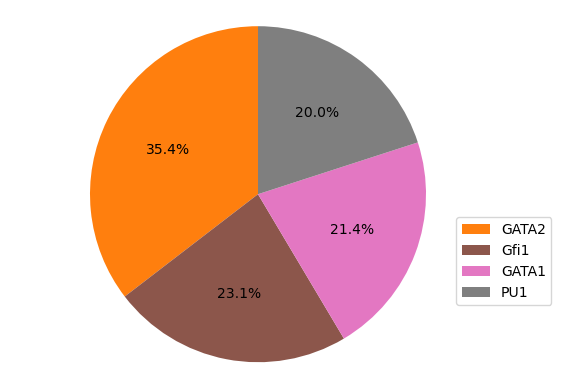

In [14]:
#H2O2 LOF
H2O2_KO = HSC_sim.copy()
maboss.set_nodes_istate(H2O2_KO, ["Oxygen"], [1, 0])
maboss.set_nodes_istate(H2O2_KO, ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"], [0.5, 0.5])
maboss.set_nodes_istate(H2O2_KO, ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"], [0, 1])
H2O2_KO.network.set_output(['GATA1', 'GATA2', 'PU1','Gfi1'])

H2O2_KO.mutate('H2O2', 'OFF')

# Run the simulation
H2O2_KO_results = H2O2_KO.run()

H2O2_KO_results.plot_piechart()


In [ ]:
#Double FOXO3 and H2O2 LOF
double_KO = HSC_sim.copy()
maboss.set_nodes_istate(double_KO, ["Oxygen"], [1, 0])
maboss.set_nodes_istate(double_KO, ["Runx1", "GATA1", "PU1", "Cebpa", "Gfi1", "Mef2c", "mTOR", "AKT", "H2O2", "O2", "OXPHOS"], [0.5, 0.5])
maboss.set_nodes_istate(double_KO, ["Meis1", "HIF1", "FOXO3", "p53", "GATA2", "Ikzf1", "AMPK", "SOD", "Antiox"], [0, 1])
double_KO.network.set_output(['GATA1', 'GATA2', 'PU1', 'Gfi1'])
double_KO.mutate('FOXO3', 'OFF')
double_KO.mutate('H2O2', 'OFF')

# Run the simulation
double_KO_results = double_KO.run()

double_KO_results.plot_piechart()
